In [2]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import wandb
import Neural_Lib_Flo as nlb
import wandb_library as wl 
import training_lib as tl
import torch.nn.functional as F
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the root directory
root_dir_sensorium = '/project/data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data'
images_path = '/project/subiculum/data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'
sub_responses_path= '/project/subiculum/data/Post_Sub_Data.mat'

# Predicting neural activity in V1 and Postsub
This notebook is the full training of models on neural data recorded in anesthetized mice that were shown natural images. The goal is to adequately well predict the activity with a correlation close to that of the model's performance on the data from the Sensorium competition which will be used as a benchmark.

## July 5th, 2024

I have already run a sweep using wandb, so this won't be done again here.

First, we will train the model on V1, Postsub and Sensorium (also V1) data to get a rough estimate of the basic model's perfromance.

In [2]:
api = wandb.Api()
run = api.run("seifertflo/V1 Training 17-06-2024/2mr3hewa")
config=run.config
v1_model=nlb.configure_model(config, 13, device)
v1_train_loader, v1_val_loader, v1_test_loader = nlb.dataloader_from_mat(images_path, v1_responses_path, 75, 125, 64)
tl.training_and_eval_with_lr(v1_model, config.get("epochs"), v1_train_loader, v1_test_loader, v1_val_loader, device, save_model=True, path_for_saving='models/v1_model.pt')

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/50], validation correlation: 0.0155, trainloss: 0.3149
Epoch [2/50], validation correlation: 0.0412, trainloss: 0.2753
Epoch [3/50], validation correlation: 0.0372, trainloss: 0.2672
Epoch [4/50], validation correlation: 0.0606, trainloss: 0.2247
Epoch [5/50], validation correlation: 0.0708, trainloss: 0.2214
Epoch [6/50], validation correlation: 0.0681, trainloss: 0.3746
Epoch [7/50], validation correlation: 0.0706, trainloss: 0.4124
Epoch [8/50], validation correlation: 0.0651, trainloss: 0.2332
Epoch     9: reducing learning rate of group 0 to 1.0000e-02.
Epoch [9/50], validation correlation: 0.0620, trainloss: 0.3230
Epoch [10/50], validation correlation: 0.0729, trainloss: 0.2154
Epoch [11/50], validation correlation: 0.0800, trainloss: 0.3165
Epoch [12/50], validation correlation: 0.0782, trainloss: 0.3942
Epoch [13/50], validation correlation: 0.0816, trainloss: 0.3153
Epoch [14/50], validation correlation: 0.0808, trainloss: 0.1987
Epoch [15/50], validation correlation

We can now use the same configuration to get a rough idea of what training with the Sub Data would give:

In [3]:
sub_train_loader, sub_val_loader, sub_test_loader =nlb.dataloader_from_mat(images_path, sub_responses_path, 75, 125, 64)
sub_run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
sub_config=sub_run.config
sub_model=nlb.configure_model(sub_config, 37, device)
tl.training_and_eval_with_lr(sub_model, config.get("epochs"),sub_train_loader, sub_val_loader, sub_test_loader, device, save_model=True, path_for_saving='models/sub_model.pt'), 

Epoch [1/50], validation correlation: 0.0475, trainloss: 0.5836
Epoch [2/50], validation correlation: 0.0699, trainloss: 0.4337
Epoch [3/50], validation correlation: 0.0731, trainloss: 0.4771
Epoch [4/50], validation correlation: 0.0789, trainloss: 0.5311
Epoch [5/50], validation correlation: 0.0707, trainloss: 0.4851
Epoch [6/50], validation correlation: 0.0802, trainloss: 0.5175
Epoch [7/50], validation correlation: 0.0891, trainloss: 0.6050
Epoch [8/50], validation correlation: 0.0974, trainloss: 0.4644
Epoch [9/50], validation correlation: 0.0887, trainloss: 0.5136
Epoch [10/50], validation correlation: 0.1037, trainloss: 0.3949
Epoch [11/50], validation correlation: 0.0937, trainloss: 0.4791
Epoch [12/50], validation correlation: 0.0926, trainloss: 0.5737
Epoch [13/50], validation correlation: 0.0932, trainloss: 0.3762
Epoch    14: reducing learning rate of group 0 to 1.0000e-02.
Epoch [14/50], validation correlation: 0.0921, trainloss: 0.4465
Epoch [15/50], validation correlation

(None,)

In [4]:
sensorium_train_loader, sensorium_val_loader, sensorium_test_loader = nlb.dataloader_from_npy_pretraining(root_dir_sensorium, device)
sensorium_model = nlb.ConvModel(layers=5, input_kern=11, hidden_kern=5, hidden_channels=32, output_dim=8372).to(device)
tl.training_and_eval_with_lr(sensorium_model, 100, sensorium_train_loader, sensorium_test_loader, sensorium_val_loader, device,gamma=1e-2,lr=1e-3, save_model=True, path_for_saving=("models/sens_model.pt"))


/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: 0.0365, trainloss: 0.8826
Epoch [2/100], validation correlation: 0.0517, trainloss: 0.7345
Epoch [3/100], validation correlation: 0.0525, trainloss: 0.6181
Epoch [4/100], validation correlation: 0.0605, trainloss: 0.4533
Epoch [5/100], validation correlation: 0.0679, trainloss: 0.5180
Epoch [6/100], validation correlation: 0.0732, trainloss: 0.5240
Epoch [7/100], validation correlation: 0.0774, trainloss: 0.4728
Epoch [8/100], validation correlation: 0.0777, trainloss: 0.5885
Epoch [9/100], validation correlation: 0.0862, trainloss: 0.5949
Epoch [10/100], validation correlation: 0.0865, trainloss: 0.5615
Epoch [11/100], validation correlation: 0.0912, trainloss: 0.6720
Epoch [12/100], validation correlation: 0.0916, trainloss: 0.5062
Epoch [13/100], validation correlation: 0.0995, trainloss: 0.4865
Epoch [14/100], validation correlation: 0.0952, trainloss: 0.5662
Epoch [15/100], validation correlation: 0.1078, trainloss: 0.5256
Epoch [16/100], val

We can also train the model on the OFF response for both postsub and V1.

In [5]:
v1_run_or = api.run("seifertflo/V1 OFF response Training 24-06-2024/tgly5e97")
v1_train_loader_or, v1_val_loader_or, v1_test_loader_or = nlb.dataloader_from_mat(images_path, v1_responses_path, time_begin=125, time_end=200, batch_size=64)
v1_or_config=v1_run_or.config
v1_or_model=nlb.configure_model(v1_or_config, 13, device)
tl.training_and_eval_with_lr(v1_or_model,100, v1_val_loader_or,v1_train_loader_or, v1_test_loader_or,device,True,0.08865963714161047,path_for_saving="/project/subiculum/code/models/v1_model_or.pt", early_stopping=False)

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: -0.0336, trainloss: -0.2867
Epoch [2/100], validation correlation: -0.0097, trainloss: -0.4659
Epoch [3/100], validation correlation: 0.0095, trainloss: -0.4008
Epoch [4/100], validation correlation: 0.0514, trainloss: -0.3310
Epoch [5/100], validation correlation: 0.0554, trainloss: -0.3569
Epoch [6/100], validation correlation: 0.0778, trainloss: -0.4300
Epoch [7/100], validation correlation: 0.0874, trainloss: -0.4729
Epoch [8/100], validation correlation: 0.0774, trainloss: -0.4339
Epoch [9/100], validation correlation: 0.0760, trainloss: -0.5264
Epoch [10/100], validation correlation: 0.0902, trainloss: -0.5197
Epoch [11/100], validation correlation: 0.1027, trainloss: -0.4729
Epoch [12/100], validation correlation: 0.1093, trainloss: -0.5302
Epoch [13/100], validation correlation: 0.0987, trainloss: -0.5063
Epoch [14/100], validation correlation: 0.0786, trainloss: -0.5529
Epoch [15/100], validation correlation: 0.0785, trainloss: -0.5358
Ep

In [7]:
sub_train_loader_or, sub_val_loader_or, sub_test_loader_or =nlb.dataloader_from_mat(images_path, sub_responses_path, 125, 200, 64)
sub_or_run = api.run("seifertflo/Sub OFF response Training 24-06-2024/bp5jezif")
sub_config_or=sub_or_run.config
sub_model_or=nlb.configure_model(sub_config_or, 37, device).to(device)
tl.training_and_eval_with_lr(sub_model_or, 100,sub_train_loader_or, sub_val_loader_or, sub_test_loader_or, device, save_model=True, path_for_saving='models/sub_model_or.pt', early_stopping=False), 

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: -0.0006, trainloss: -0.1983
Epoch [2/100], validation correlation: -0.0090, trainloss: -0.0338
Epoch [3/100], validation correlation: 0.0226, trainloss: 0.0173
Epoch [4/100], validation correlation: 0.0352, trainloss: 0.3476
Epoch [5/100], validation correlation: 0.0301, trainloss: 0.6404
Epoch [6/100], validation correlation: 0.0355, trainloss: 0.2727
Epoch [7/100], validation correlation: 0.0375, trainloss: -0.1494
Epoch [8/100], validation correlation: 0.0254, trainloss: -0.1319
Epoch [9/100], validation correlation: 0.0447, trainloss: -0.0526
Epoch [10/100], validation correlation: 0.0418, trainloss: -0.2655
Epoch [11/100], validation correlation: 0.0445, trainloss: 0.0242
Epoch [12/100], validation correlation: 0.0388, trainloss: 0.1989
Epoch    13: reducing learning rate of group 0 to 1.0000e-02.
Epoch [13/100], validation correlation: 0.0423, trainloss: 0.0924
Epoch [14/100], validation correlation: 0.0438, trainloss: 0.0458
Epoch [15/100],

(None,)

As one gets a correlation of ~30% for the Sensorium data, it would be helpful to understand why this is not reached for the v1 data here. 

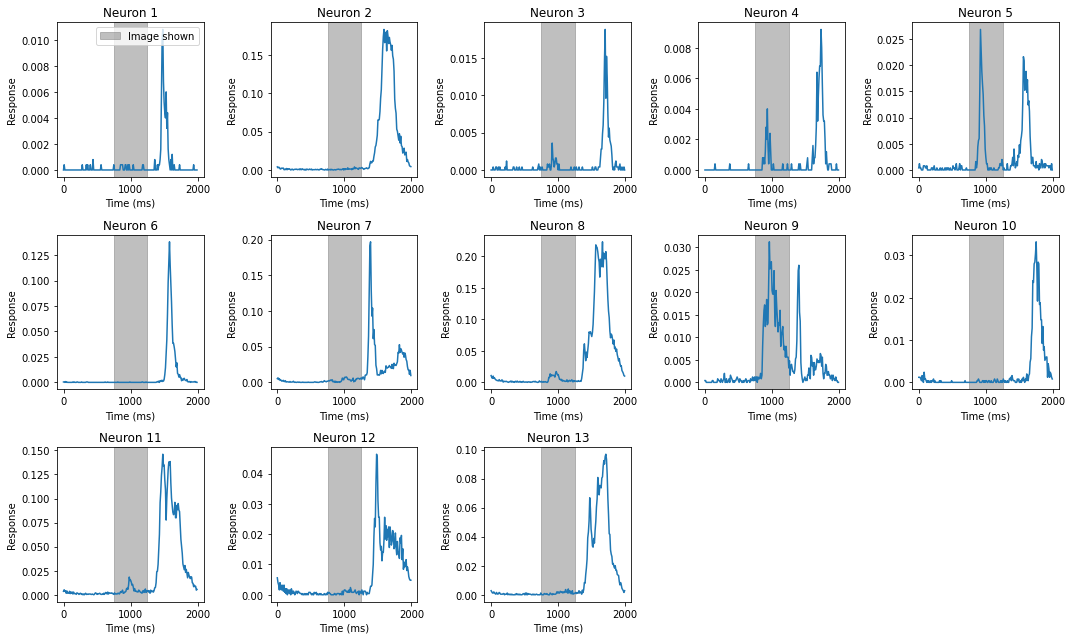

In [14]:
nlb.plot_avrg_response(images_path, v1_responses_path)

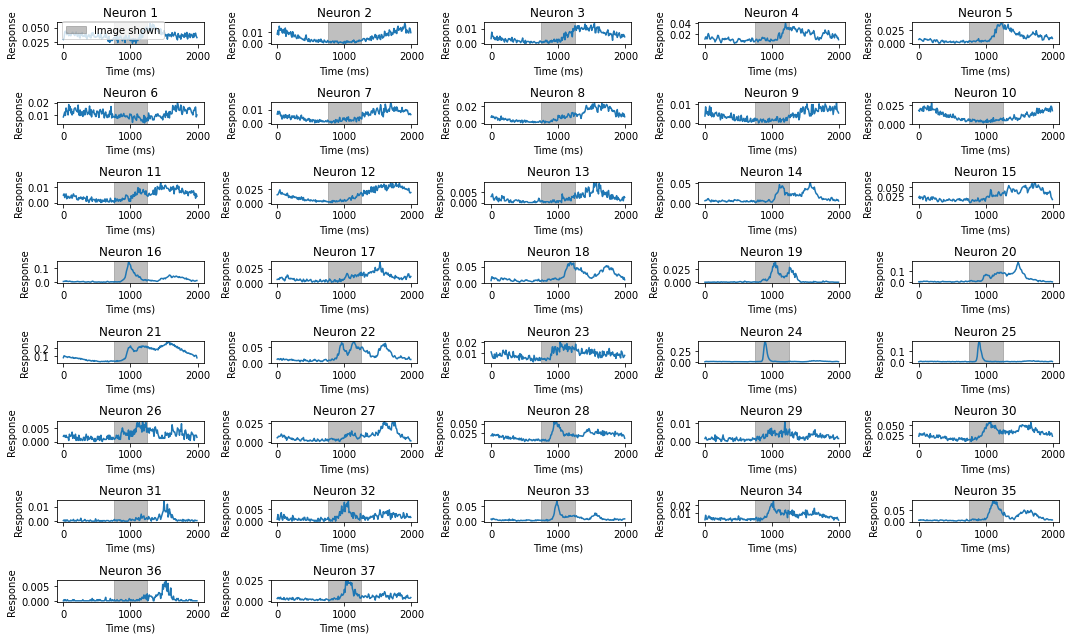

In [15]:
nlb.plot_avrg_response(images_path, sub_responses_path)

## Spike triggered averages

Shows the STA for the best neurons (in terms of correlation on the validation loader):
torch.Size([5994])
Processing neuron 1732...
Processing neuron 2574...
Processing neuron 1503...
Processing neuron 7019...
Processing neuron 322...
Processing neuron 8279...
Processing neuron 6430...
Processing neuron 4020...
Processing neuron 746...
Processing neuron 4741...
Processing neuron 4774...
Processing neuron 1872...


/project/subiculum/code/Neural_Lib_Flo.py:948: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


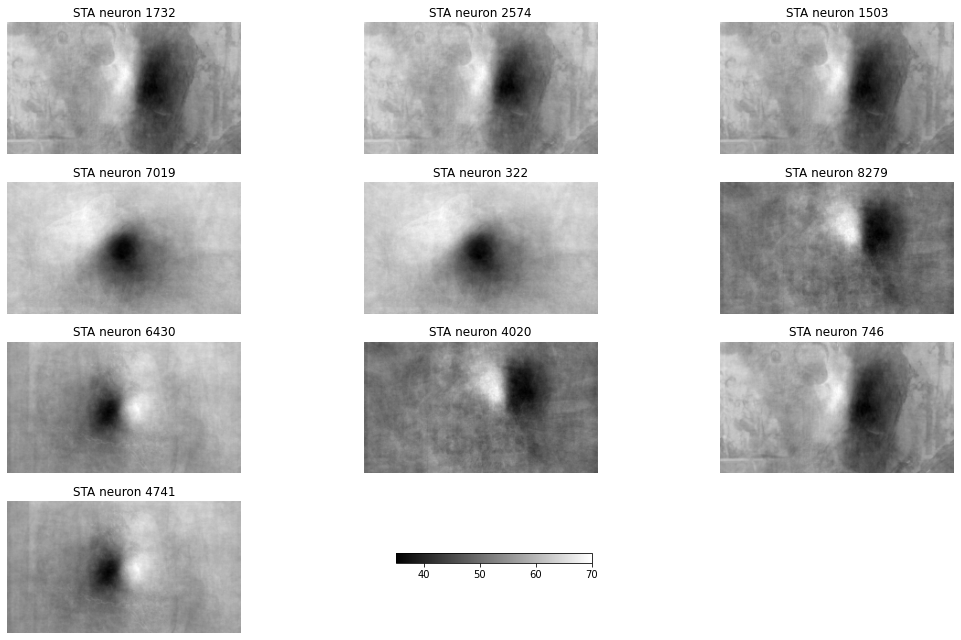

In [16]:
state_dict_sens = torch.load('models/sens_model.pt')
sensorium_model.load_state_dict(state_dict_sens)
sensorium_model.to(device)
with torch.no_grad():
    sens_val_corrs = nlb.get_correlations(sensorium_model, sensorium_val_loader, device)
best_neurons_sens = np.argsort(-sens_val_corrs)
nlb.sta_wo_model(device,best_neurons_sens, root_dir_sensorium)

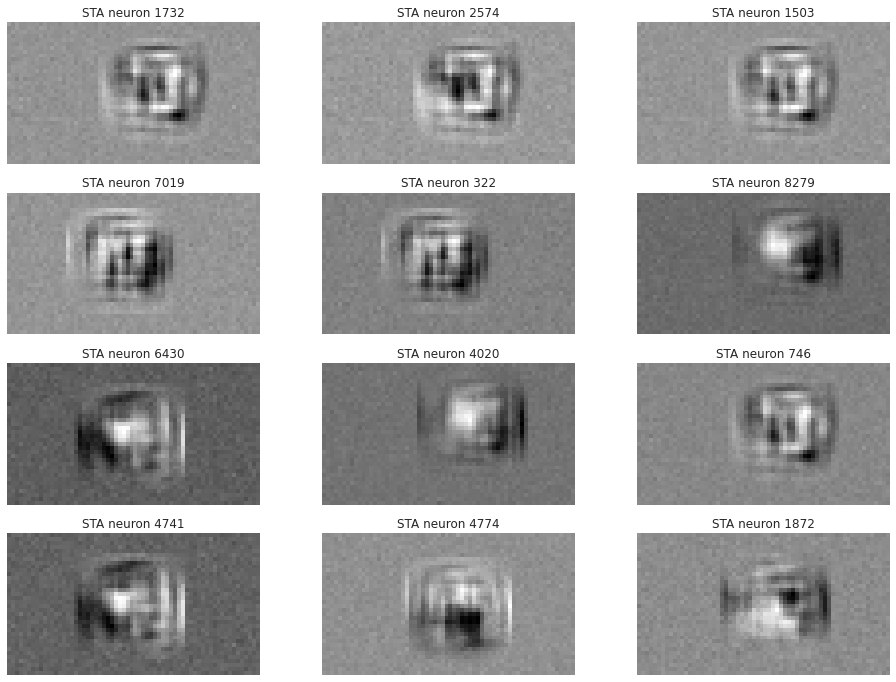

In [17]:
nlb.STA_model_sens(sensorium_model, 'models/sens_model.pt', best_neurons_sens)

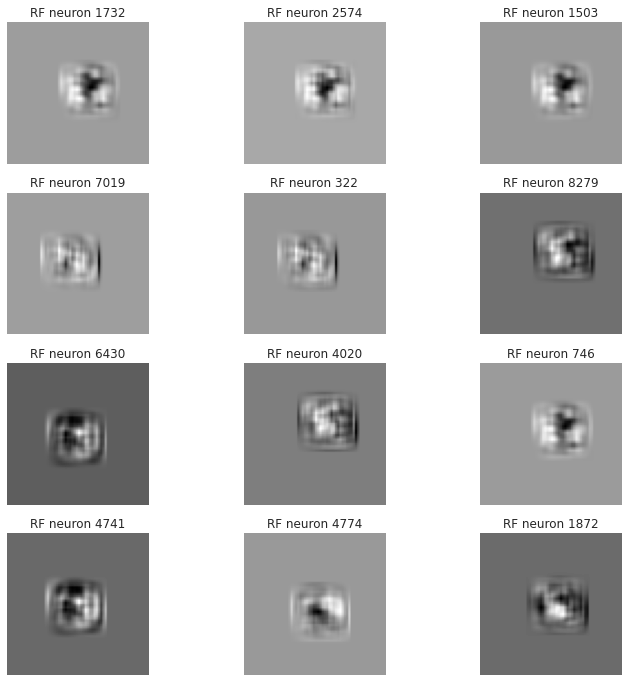

In [19]:
nlb.gradientRF(sensorium_model,'models/sens_model.pt',best_neurons_sens,device)

### For V1 and Postsub

/project/subiculum/code/Neural_Lib_Flo.py:905: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)


torch.Size([2500, 64, 64])
torch.Size([13, 2500])


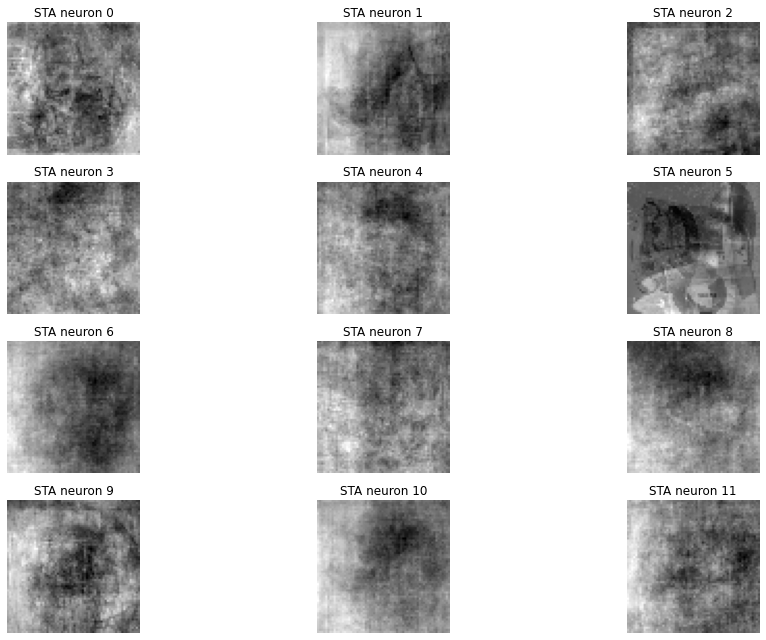

In [20]:
neurons_v1=[0,1,2,3,4,5,6,7,8,9,10,11,12]
nlb.sta_wo_model(device, neurons_v1 ,v1_responses_path, images_path,data_is_npy=False)

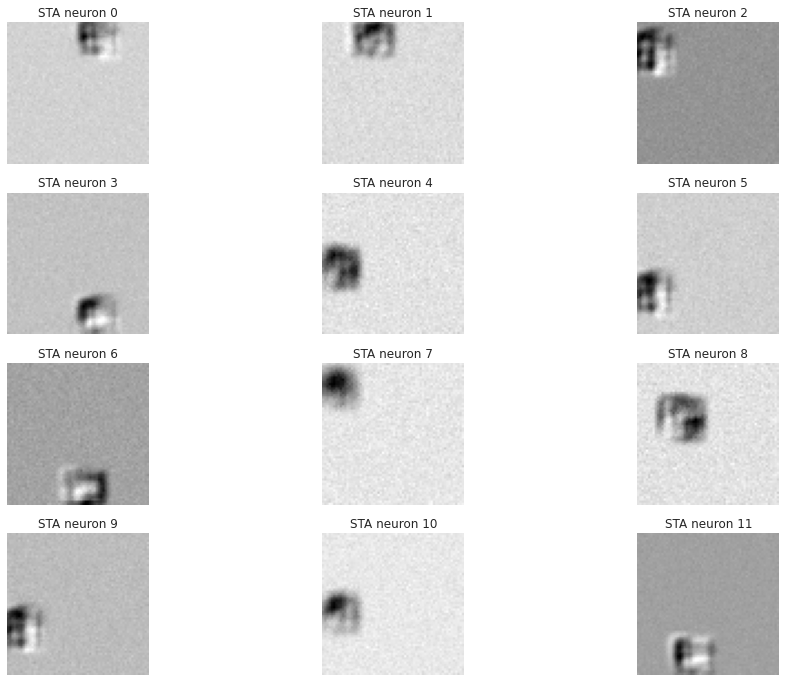

In [21]:
nlb.STA_model(v1_model, 'models/v1_model.pt', neurons_v1)

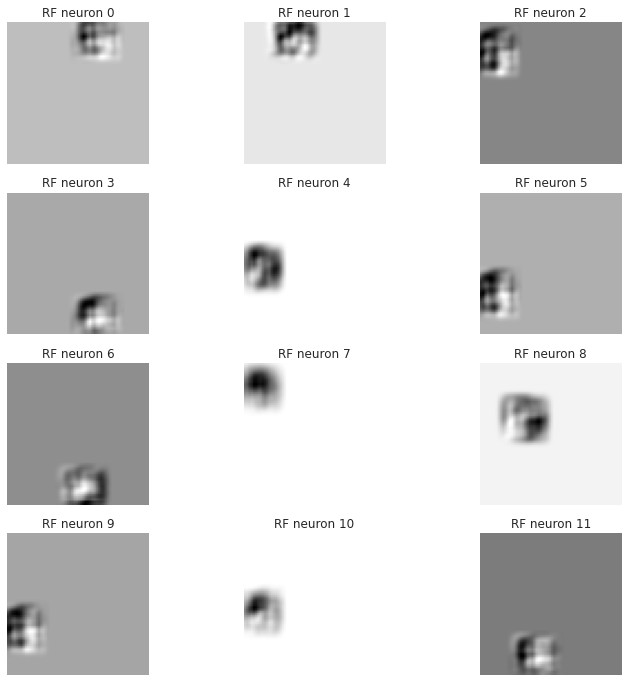

In [22]:
nlb.gradientRF(v1_model, 'models/v1_model.pt', neurons_v1,device)

/project/subiculum/code/Neural_Lib_Flo.py:905: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)


torch.Size([2500, 64, 64])
torch.Size([13, 2500])


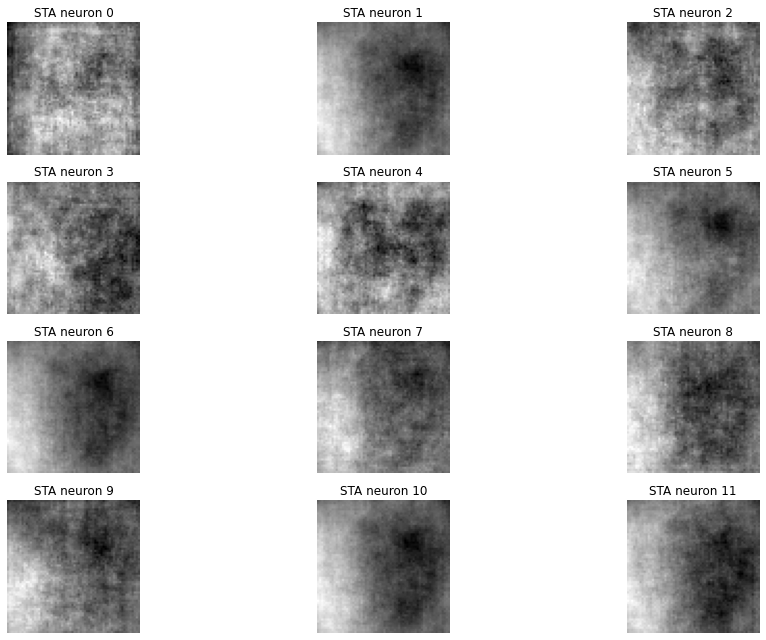

In [23]:
nlb.sta_wo_model(device, neurons_v1 ,v1_responses_path, images_path,data_is_npy=False, index_start=125,index_end=200)

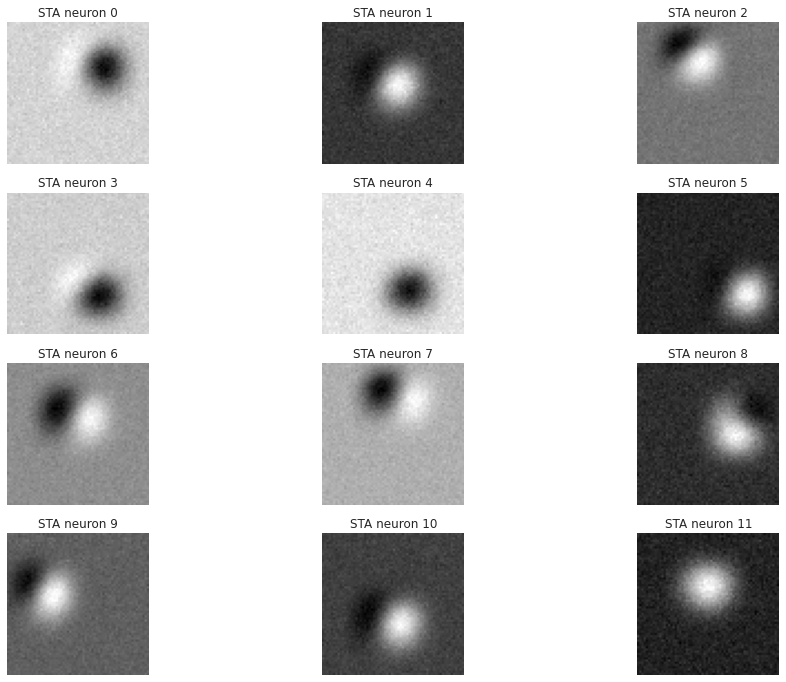

In [24]:
nlb.STA_model(v1_or_model, 'models/v1_model_or.pt', neurons_v1)

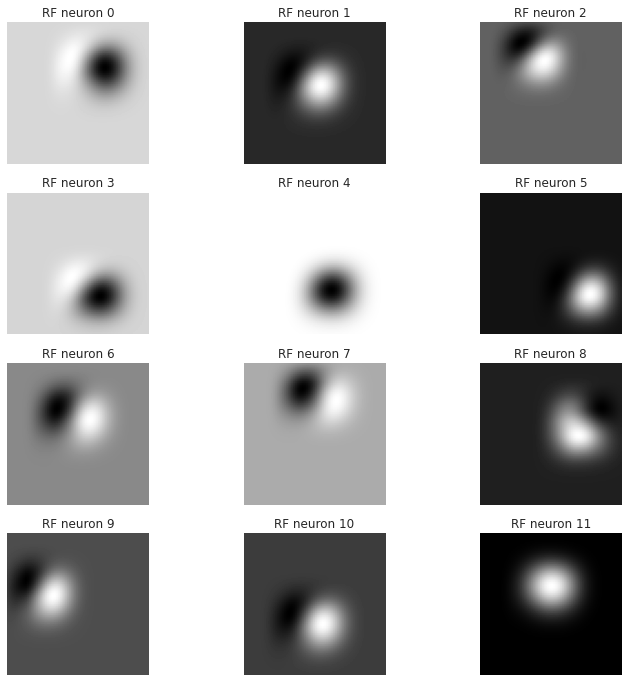

In [25]:
nlb.gradientRF(v1_or_model, 'models/v1_model_or.pt', neurons_v1,device)

torch.Size([2500, 64, 64])
torch.Size([37, 2500])


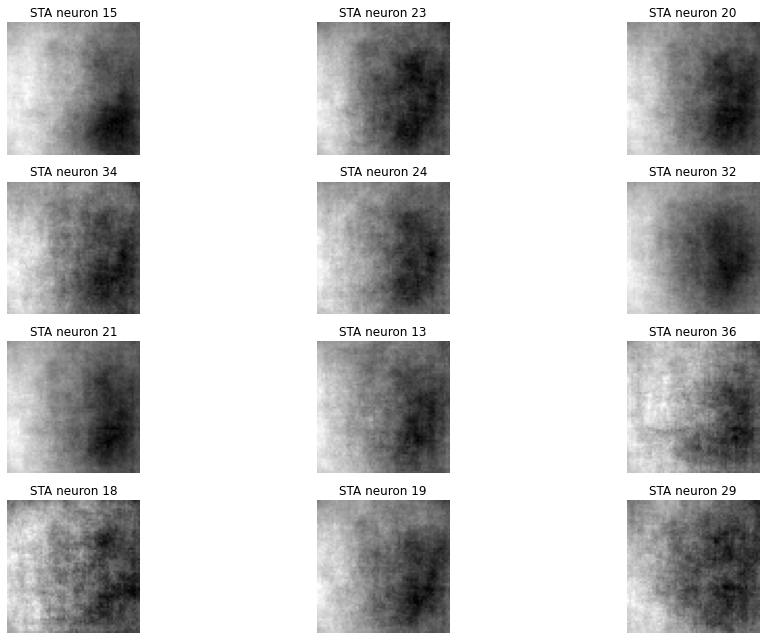

In [29]:
api = wandb.Api()
run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
config=run.config
sub_model=nlb.configure_model(config, 37, device)
sub_state_dict=torch.load('models/sub_model.pt')
sub_model.load_state_dict(sub_state_dict)
with torch.no_grad():
    sub_val_corrs = nlb.get_correlations(sub_model, sub_val_loader, device)
best_neurons_sub = np.argsort(-sub_val_corrs)
nlb.sta_wo_model(device, best_neurons_sub ,sub_responses_path, images_path,data_is_npy=False)


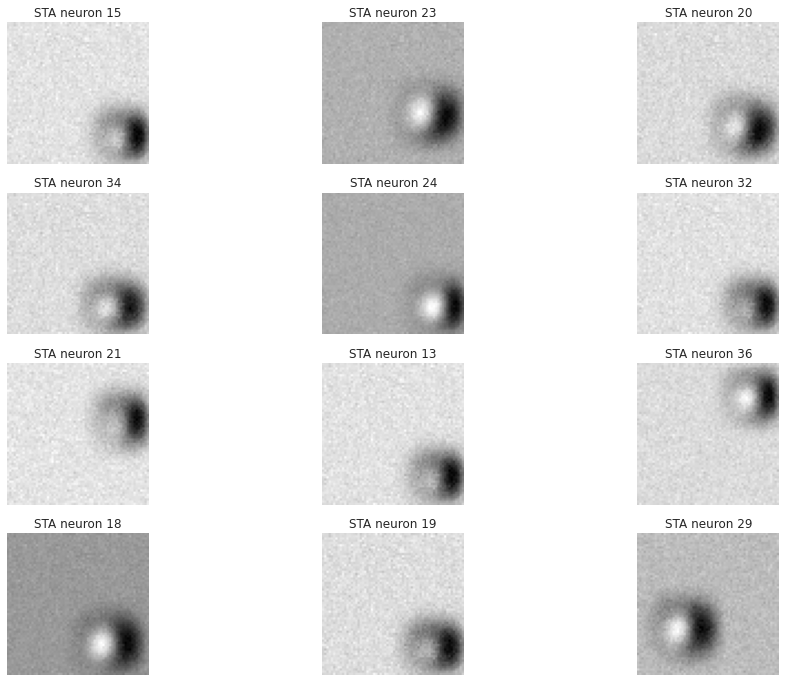

In [30]:
nlb.STA_model(sub_model, 'models/sub_model.pt', best_neurons_sub)

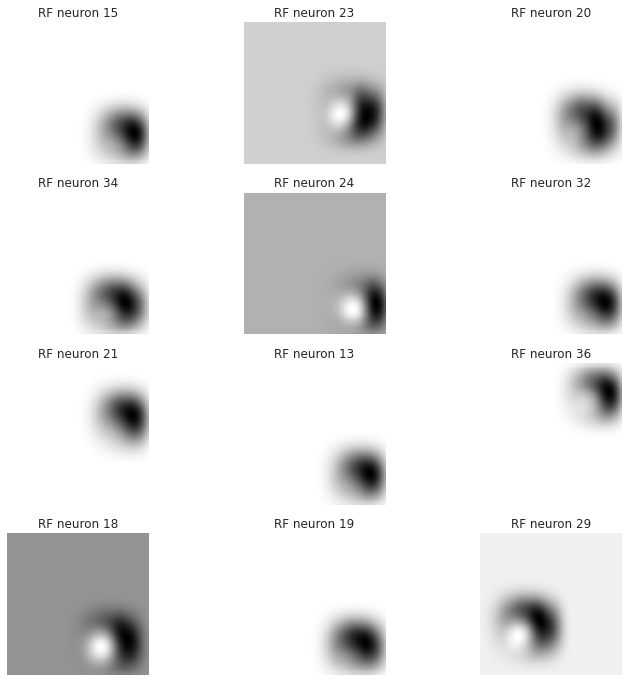

In [31]:
nlb.gradientRF(sub_model, 'models/sub_model.pt', best_neurons_sub,device)

For the off response the best predicted neurons in the postsub are different neurons, hence the different numbers!

In [32]:
with torch.no_grad():
    sub_val_corrs_or = nlb.get_correlations(sub_model_or, sub_val_loader_or, device)
best_neurons_sub_or = np.argsort(-sub_val_corrs_or)

torch.Size([2500, 64, 64])
torch.Size([37, 2500])


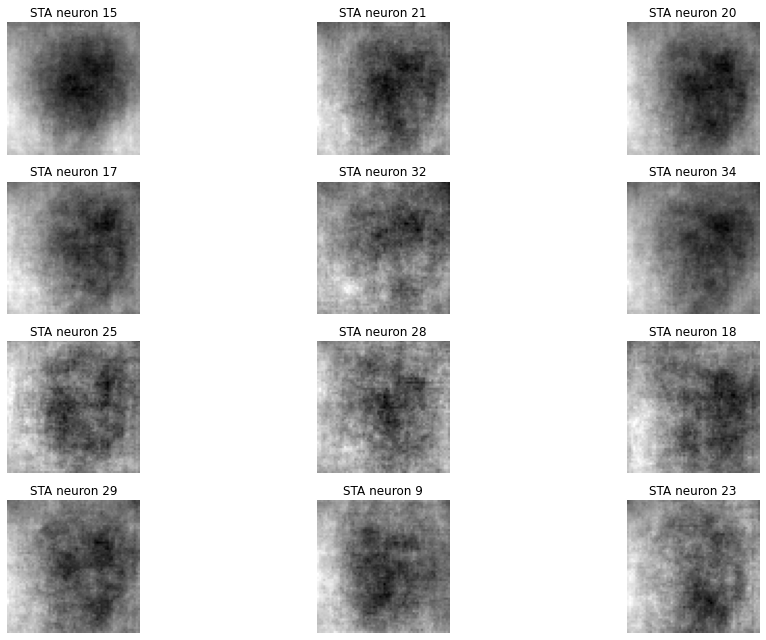

In [33]:
nlb.sta_wo_model(device, best_neurons_sub_or ,sub_responses_path, images_path,data_is_npy=False, index_start=125, index_end=200)

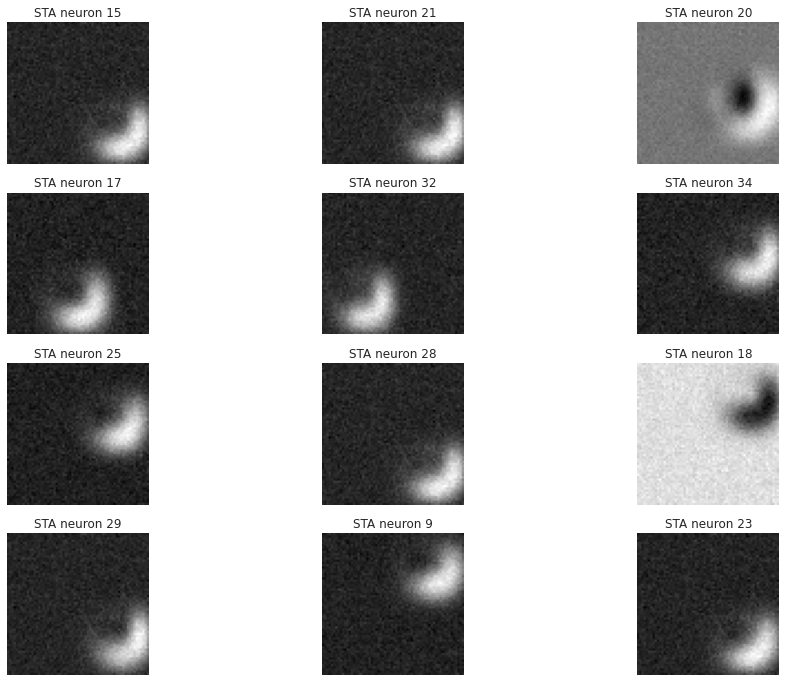

In [34]:
nlb.STA_model(sub_model_or, 'models/sub_model_or.pt', best_neurons_sub_or)

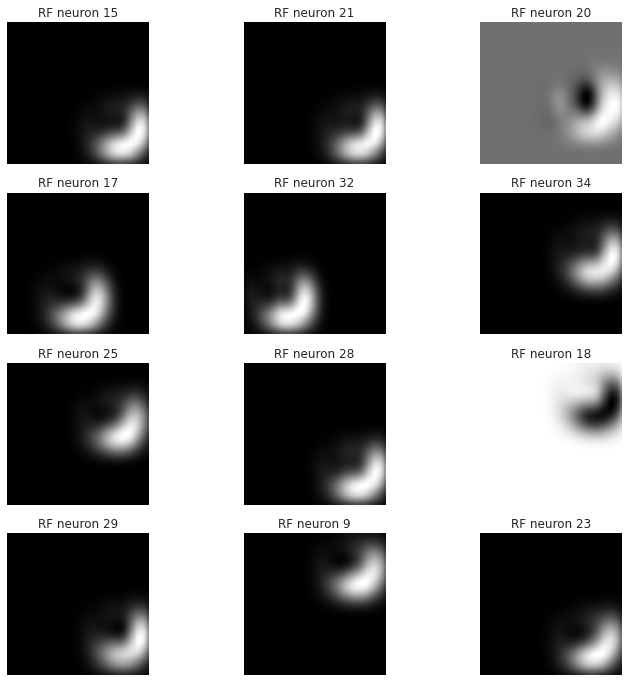

In [35]:
nlb.gradientRF(sub_model_or, 'models/sub_model_or.pt', best_neurons_sub_or,device)

## Changes to the model
1. Different readout
2. Depth separable convolutions

$\rightarrow$ compare the results, especially the position of the receptive fields to the predicitons of the basic model.

In [49]:
run = api.run("seifertflo/V1 Training 17-06-2024/2mr3hewa")
config=run.config
v1_model_factorized = nlb.configure_model(config,13,device,False, reg_weight=0.5)
tl.training_and_eval_with_lr(v1_model_factorized,100,v1_train_loader, v1_test_loader, v1_val_loader, device,True,lr=1e-4,path_for_saving='models/v1_model_factorized.pt')


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: 0.0423, trainloss: 0.7674
Epoch [2/100], validation correlation: 0.0342, trainloss: 0.6431
Epoch [3/100], validation correlation: 0.0758, trainloss: 0.4979
Epoch [4/100], validation correlation: 0.0184, trainloss: 0.4430
Epoch [5/100], validation correlation: 0.0912, trainloss: 0.3408
Epoch [6/100], validation correlation: 0.0880, trainloss: 0.3545
Epoch [7/100], validation correlation: 0.0868, trainloss: 0.3518
Epoch [8/100], validation correlation: 0.0612, trainloss: 0.3546
Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
Epoch [9/100], validation correlation: 0.0898, trainloss: 0.3793
Epoch [10/100], validation correlation: 0.0908, trainloss: 0.4108
Early stopping triggered!

model saved as models/v1_model_factorized.pt
Test Loss: 0.3139
Test Correlation: 0.1280


In [50]:
print(config.get("layers"))

3


In [54]:
run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
config=run.config
print(config.get("layers"))
sub_model_factorized=nlb.configure_model(config, 37, device, False, reg_weight=0.5, fact_input=40)
print(sub_model_factorized)
tl.training_and_eval_with_lr(sub_model_factorized,100,sub_train_loader, sub_test_loader, sub_val_loader, device,True,lr=1e-4,path_for_saving='models/sub_model_factorized.pt')

5
ConvModel(
  (conv_layers): Sequential()
  (core): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU()
  )
  (re

Epoch [1/100], validation correlation: 0.0137, trainloss: 1.1591
Epoch [2/100], validation correlation: 0.0282, trainloss: 1.0044
Epoch [3/100], validation correlation: 0.0388, trainloss: 0.8943
Epoch [4/100], validation correlation: 0.0597, trainloss: 0.9355
Epoch [5/100], validation correlation: 0.0467, trainloss: 0.8471
Epoch [6/100], validation correlation: 0.0322, trainloss: 0.8523
Epoch [7/100], validation correlation: 0.0341, trainloss: 0.8542
Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
Epoch [8/100], validation correlation: 0.0444, trainloss: 0.8626
Epoch [9/100], validation correlation: 0.0489, trainloss: 0.8371
Early stopping triggered!

model saved as models/sub_model_factorized.pt
Test Loss: 0.7618
Test Correlation: 0.0437


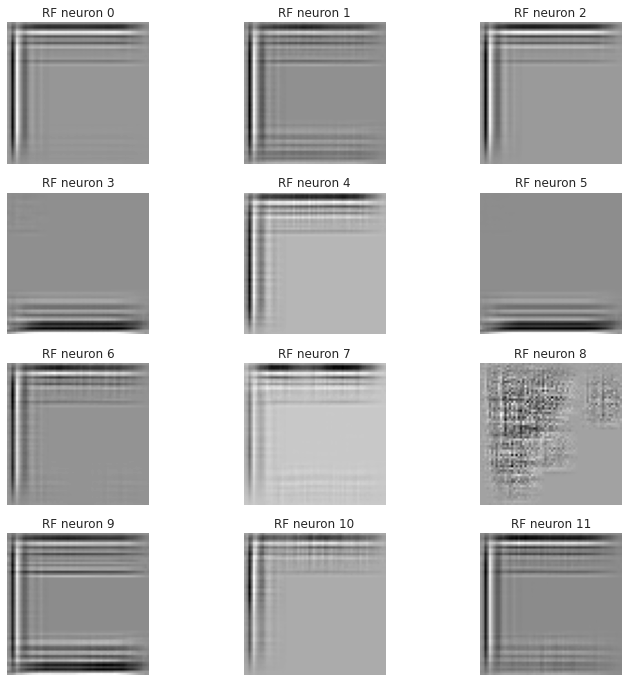

In [57]:
nlb.gradientRF(v1_model_factorized, 'models/v1_model_factorized.pt', neurons_v1,device)

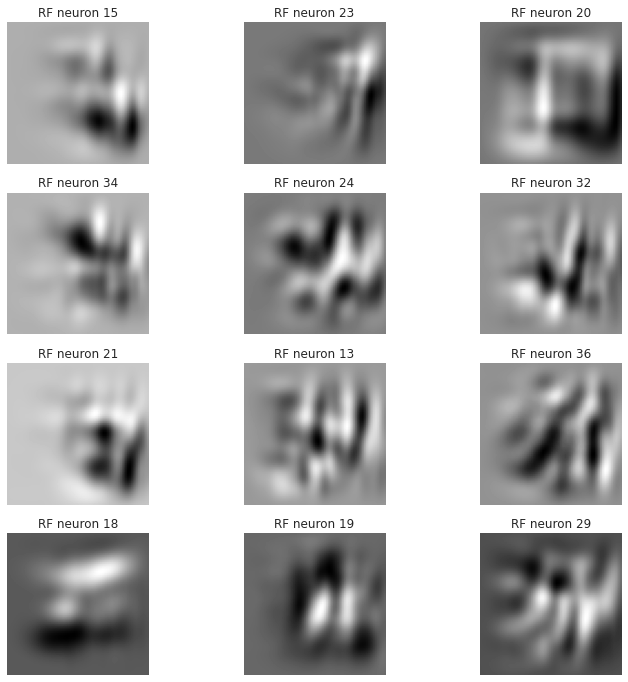

In [56]:
nlb.gradientRF(sub_model_factorized, 'models/sub_model_factorized.pt', best_neurons_sub,device)


In [3]:
sub_train_loader, sub_val_loader, sub_test_loader =nlb.dataloader_from_mat(images_path, sub_responses_path, 75, 125, 64)
api = wandb.Api()
run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
config=run.config
print(config.get("layers"))
sub_ds_model_factorized=nlb.configure_depth_sep_model(config, 37, device, False, reg_weight=0.5, fact_input=40)
print(sub_ds_model_factorized)
tl.training_and_eval_with_lr(sub_ds_model_factorized,100,sub_train_loader, sub_test_loader, sub_val_loader, device,True,lr=1e-4,path_for_saving='models/sub_ds_model_factorized.pt')

5


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


DepthSepConvModel(
  (core): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2), groups=128)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2), groups=128)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2), groups=128)
      (poi

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: -0.0107, trainloss: 1.1799
Epoch [2/100], validation correlation: 0.0050, trainloss: 1.0479
Epoch [3/100], validation correlation: -0.0019, trainloss: 0.9892
Epoch [4/100], validation correlation: 0.0162, trainloss: 1.0657
Epoch [5/100], validation correlation: 0.0300, trainloss: 0.9162
Epoch [6/100], validation correlation: 0.0219, trainloss: 0.9909
Epoch [7/100], validation correlation: 0.0264, trainloss: 0.8411
Epoch [8/100], validation correlation: 0.0176, trainloss: 0.8519
Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
Epoch [9/100], validation correlation: 0.0049, trainloss: 0.8696
Epoch [10/100], validation correlation: 0.0244, trainloss: 0.8048
Early stopping triggered!

model saved as models/sub_ds_model_factorized.pt
Test Loss: 0.7867
Test Correlation: 0.0142


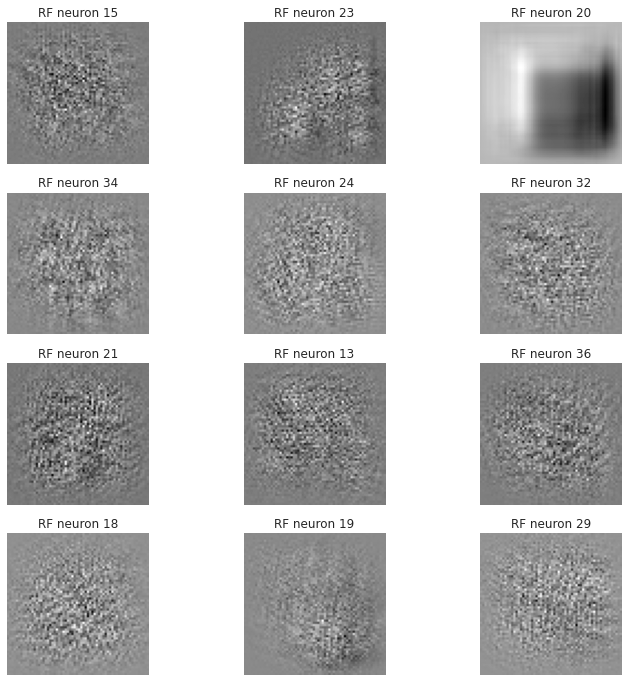

In [5]:
best_neurons_sub=[15,23,20,34,24,32,21,13,36,18,19,29]
nlb.gradientRF(sub_ds_model_factorized, 'models/sub_ds_model_factorized.pt', best_neurons_sub,device)

In [ ]:
v1_train_loader, v1_val_loader, v1_test_loader = nlb.dataloader_from_mat(images_path, v1_responses_path, 75, 125, 64)